In [1]:
# Final Thesis Report: Sentiment Analysis in Sports and Outdoors Product Reviews Using Machine Learning (September 2024)
# Student: Manh Nguyen Hung

# Note:
# The program in this file is an extension to the program in the file "01.sentiment_analysis_dev_v2.ipynb"
# This file will focus on visualizing the results after the Sentiment Detection step.

# Content Table
<a id='menu'></a>

1. [Libraries Import](#m-1)
2. [Environment Configuration](#m-2)
3. [Sentiment Detection (extension for section 11)](#m-3) \
   3.1 [Visualize Result after Sentiment Detection](#m-3-1) \
   3.2 [Result](#m-3-2)

# 1. Libraries Import ([menu](#menu)) <a id='m-1'></a>

In [2]:
!pip install wordcloud

In [3]:
!pip install -U imbalanced-learn

In [4]:
!pip install xgboost

In [5]:
import time
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import scipy.sparse as sp
import seaborn as sns
import spacy
import string

from abc import ABC, abstractmethod
from datetime import datetime
from tqdm import tqdm
%matplotlib inline

In [6]:
from imblearn.over_sampling import BorderlineSMOTE

import multiprocessing
from multiprocessing import Manager

import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

import pickle
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB

import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import xgboost
from xgboost import XGBClassifier

In [7]:
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# 2. Environment Configuration ([menu](#menu)) <a id='m-2'></a>

In [8]:
# Set True to execute code by using Google Colab
# Set False to execute code by using local computer
USE_COLAB=True

In [9]:
# If Google Colab is used, add google.colab library
if USE_COLAB:
  from google.colab import drive

In [10]:
# If Google Colab is used, mount Google Drive to Colab System
if USE_COLAB:
  drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [11]:
# Define the root path for working directory
root_path = "/content/gdrive/MyDrive/Master-Thesis/master-thesis-sentiment-analysis" if USE_COLAB else '.'

In [12]:
# Define the path for Amazon Reviews 2023 directory
data_path = f"{root_path}/datasets/temp/Amazon Reviews 2023"

In [13]:
# Define the path for models irectory
model_path = f"{root_path}/models"

# 3. Sentiment Detection (extension for section 11) ([menu](#menu)) <a id='m-3'></a>

#### Restore Results from Sentiment Detection Step (Optional)

In [14]:
%%time
# Restore data from Sentiment Detection Step
restore_path_3 = f"{data_path}/Product_Reviews_Sentiment.zip"

if 'df' not in globals():
  if os.path.exists(restore_path_3):
    print(f"Read data from Product_Reviews_Sentiment.zip")
    df = pd.read_json(restore_path_3, orient="records", lines=True, compression="zip")
  else:
    print(f"{restore_path_3} not found")

Read data from Product_Reviews_Sentiment.zip
CPU times: user 1min 46s, sys: 45.7 s, total: 2min 32s
Wall time: 2min 30s


### Function Helpers

In [15]:
# Function: count number of values for each sentiment state
def group_by_sentiment_states(data_series):
    df_temp = data_series.value_counts().to_frame()
    df_temp["percentage"] = (df_temp["count"] / df_temp["count"].sum()) * 100
    return df_temp

# Function: describe all sentiment columns
def describe_sentiment_states(data_frame):
    sentiment_columns = [
        "review_raw_sentiment",
        "review_cleaned_sentiment",
        "review_lemmatized_sentiment",
        "rating_sentiment",
        "final_sentiment"
    ]

    df_temp = (
        pd.concat(
            objs=[group_by_sentiment_states(data_frame[x]) for x in sentiment_columns],
            keys=sentiment_columns,
            axis=1
        )
        .reset_index(names=["sentiment"])
        .replace({"sentiment": {1: "positive", 0: "neutral", -1: "negative"}})
    )

    df_count = pd.melt(
        df_temp,
        id_vars=[("sentiment", "")],
        var_name="sentiment_source",
        value_name="sentiment_count",
        value_vars=[(x, "count") for x in sentiment_columns])

    df_percentage = pd.melt(
        df_temp,
        id_vars=[("sentiment", "")],
        var_name="sentiment_source",
        value_name="sentiment_percentage",
        value_vars=[(x, "percentage") for x in sentiment_columns])

    return (
        df_count
        .merge(df_percentage, on=[("sentiment", ""), "sentiment_source"])
        .rename(columns={("sentiment", ""): "sentiment"})
        .replace({"sentiment": {1: "positive", 0: "neutral", -1: "negative"}})
    )

In [16]:
# Function: set plot information
def set_plot_info(title=None, xlabel=None, ylabel=None, rotation=0, axis=None):
    if title:
      axis.set_title(title)

    if xlabel:
      axis.set_xlabel(xlabel)

    if ylabel:
      axis.set_ylabel(ylabel)

    if rotation > 0:
      axis.set_xticklabels(axis.get_xticklabels(), rotation=rotation)

    return axis

# Function: set plot metric
def set_plot_metric(use_k_style, metric_type, count, percentage, x, y, axis=None):
    if metric_type == "count":
      axis.annotate('{0}K'.format(int(count//1000)) if use_k_style else '{0}'.format(count), (x, y), ha='center')
    elif metric_type == "percentage":
      axis.annotate('{0:.1f}%'.format(percentage), (x, y), ha='center')
    elif metric_type == "both":
        axis.annotate('{0}K / {1:.1f}%'.format(int(count//1000), percentage) if use_k_style else '{0} / {1:.1f}%'.format(count, percentage), (x, y), ha='center')
    else:
        None
    return axis

In [17]:
# Function: visualize sentiment state information of each columns
def visualize_sentiment_states(data_frame, title=None, xlabel=None, ylabel=None, rotation=0, use_k_style=False, metric_type=None, display_metric_margin=5, axis=None):
    ax = sns.barplot(x=data_frame["sentiment"], y=data_frame["sentiment_count"], hue=data_frame["sentiment_source"], palette="GnBu", ax=axis)

    patches = sorted(list(map(lambda p: (p.get_x(), p.get_width(), p.get_height()), ax.patches)), key=lambda x: x[2], reverse=True)
    for i in range(len(patches)):
        if patches[i] == (0, 0, 0):
            continue
        x = patches[i][0] + patches[i][1]/ 2
        y = patches[i][2] + display_metric_margin
        set_plot_metric(use_k_style, metric_type, patches[i][2], data_frame[data_frame["sentiment_count"] == patches[i][2]].iloc[0]["sentiment_percentage"], x, y, ax)

    return set_plot_info(title, xlabel, ylabel, rotation, ax)

## 3.1 Visualize Result after Sentiment Detection ([menu](#menu)) <a id='m-3-1'></a>

In [18]:
df_sentiment_columns = describe_sentiment_states(df)

In [19]:
df_sentiment_columns

,sentiment,sentiment_source,sentiment_count,sentiment_percentage
0,positive,review_raw_sentiment,12689314,69.578567
1,neutral,review_raw_sentiment,4365353,23.936283
2,negative,review_raw_sentiment,1182722,6.485150
3,positive,review_cleaned_sentiment,13099260,71.826400
4,neutral,review_cleaned_sentiment,4348700,23.844970
5,negative,review_cleaned_sentiment,789429,4.328629
6,positive,review_lemmatized_sentiment,12925777,70.875151
7,neutral,review_lemmatized_sentiment,4586200,25.147240
8,negative,review_lemmatized_sentiment,725412,3.977609
9,positive,rating_sentiment,14245485,78.111428


<Axes: title={'center': 'Number of Product Reviews by Sentiment State'}, xlabel='Sentiment State', ylabel='Number of Product Review'>

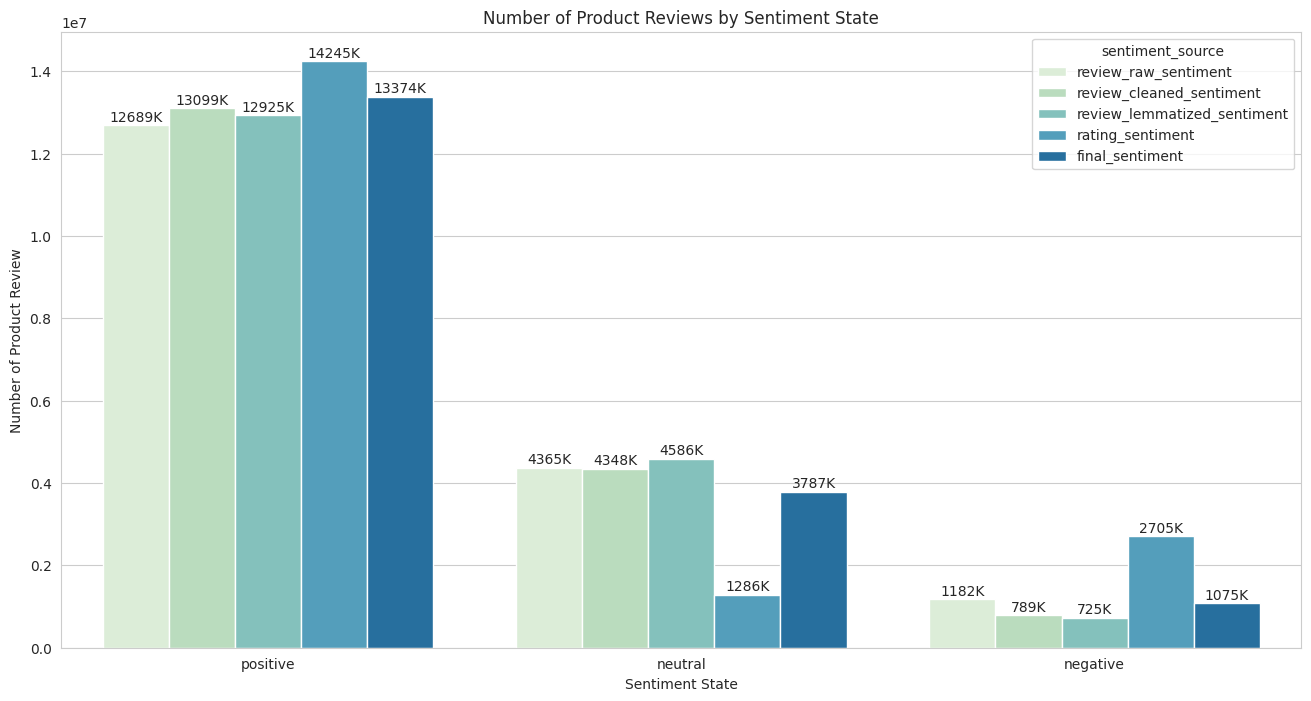

In [20]:
plt.figure(figsize=(16, 8))
sns.set_style("whitegrid")

visualize_sentiment_states(
    data_frame=df_sentiment_columns,
    title="Number of Product Reviews by Sentiment State",
    xlabel="Sentiment State",
    ylabel="Number of Product Review",
    use_k_style=True,
    metric_type="count",
    display_metric_margin=100_000
)

## 3.2 Results ([menu](#menu)) <a id='m-3-2'></a>

In [21]:
# Print data frame shape
df.shape

(18237389, 9)

In [22]:
# Print all column names
df.columns

Index(['review_lemmatized', 'review_raw_sentiment', 'review_cleaned_sentiment',
       'review_lemmatized_sentiment', 'rating_sentiment', 'total_points',
       'neutral_count', 'adjusted_total_points', 'final_sentiment'],
      dtype='object')

In [23]:
# Print first 20 rows
df.head(20)

,review_lemmatized,review_raw_sentiment,review_cleaned_sentiment,review_lemmatized_sentiment,rating_sentiment,total_points,neutral_count,adjusted_total_points,final_sentiment
0,crazy comfy gon lie look lol luckily ppl value...,1,1,1,1,4,0,4.0,1
1,excellent love pretty,1,1,1,1,4,0,4.0,1
2,good saddle pad huge fan vertigo dressage pad ...,1,1,1,1,4,0,4.0,1
3,perfect repair kit great weaver halter recentl...,1,1,1,1,4,0,4.0,1
4,work great great slightly tooshort girth sturd...,1,1,1,1,4,0,4.0,1
5,great stirrup bar grip grip pretty great great...,1,1,1,1,4,0,4.0,1
6,perfect perfect boy look adorable love padding...,1,1,1,1,4,0,4.0,1
7,awesome leather amazing trainer notice right a...,1,1,1,1,4,0,4.0,1
8,nice product size product sizing way woman pur...,1,1,1,1,4,0,4.0,1
9,mixed feeling love chalk bag online person lik...,1,1,1,1,4,0,4.0,1
